# Øvelse 4 - Digital Nomads

I denne øvelse kommer vi til, at arbejde med datamanipulation, merging af DataFrames og visualiseringer af forskellige variable. Vi kommer til primært til at kigge på hvordan man kan sikre sig, at ens data har rimelige værdier, hvordan man kan berige sin data ved, at slå flere DataFrames sammen, og hvordan man kan bruge dette til at skabe nogle mere sigende visualiseringer.

In [38]:
# Vi importerer de nødvendige libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Vi importerer vores data
trips_data = pd.read_csv('https://sds-aau.github.io/SDS-master/M1/data/trips.csv')
people_data = pd.read_csv('https://sds-aau.github.io/SDS-master/M1/data/people.csv')
country_data = pd.read_csv('https://sds-aau.github.io/SDS-master/M1/data/countrylist.csv')

In [40]:
# Vi konverterer det importerede data til DataFrames
trips = pd.DataFrame(trips_data)
people = pd.DataFrame(people_data)
country = pd.DataFrame(country_data)

## 1 - Datamanipulation og Overblik

In [41]:
# 1.1: Hvordan ser de første 5 rækker af trips dataframen ud og hvilke kolonner arbejder vi med?
trips.head()

,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug
0,0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,2018-06-04,21,-101,Guanajuato,mexico
1,1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,2018-05-31,19,-99,Mexico City,mexico-city-mexico
2,2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,2017-11-01,21,-86,Cancun,cancun-mexico
3,3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,2017-07-24,31,35,Amman,amman-jordan
4,4,@waylandchin,China,CN,china,2017-03-18,2017-02-17,40,122,Yingkou,china


In [42]:
# 1.2: Er der nogle rækker med manglende data i trips dataframen?
# 1.3: Hvilke datatyper arbejder vi med?
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46510 entries, 0 to 46509
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    46510 non-null  int64 
 1   username      46510 non-null  object
 2   country       46473 non-null  object
 3   country_code  45909 non-null  object
 4   country_slug  46473 non-null  object
 5   date_end      46335 non-null  object
 6   date_start    46510 non-null  object
 7   latitude      46510 non-null  int64 
 8   longitude     46510 non-null  int64 
 9   place         46510 non-null  object
 10  place_slug    46473 non-null  object
dtypes: int64(3), object(8)
memory usage: 3.9+ MB


Som det kan ses har vi to kolonner i vores `trips` DataFrame som er af datatypen `object`. Vi vil gerne have at datoer i vores DataFrames er formatteret som `datetime`. Her kan vi bruge funnktionen `pd.to_datetime()` til at konvertere vores kolonner til datatypen `datetime`. Her er vi nødt til, at bruge parametret `errors='coerce'` for, at sikre at fejl bliver håndteret korrekt.

In [43]:
# 1.4: Konverter kolonnerne date_end og date_start til datatypen datetime.
trips['date_start'] = pd.to_datetime(trips['date_start'], errors='coerce')
trips['date_end'] = pd.to_datetime(trips['date_end'], errors='coerce')

Vi konverterer igen vores to datokolonner til `datetime`. Dette er en god ide at gøre hver gang man arbejder med datoer i en DataFrame. Vi bruger parametret `errors='coerce'` for at fortælle DataFramen, at den skal medtage de fejl der er men give dem værdien `NaT` (Not a Time).

In [44]:
# 1.5: Udregn længden af rejserne i kolonnen trip_duration:
# Dette kan gøres ved at trække slut tidspunktet fra startstidspunktet. 
trips['trip_duration'] = (trips['date_end'] - trips['date_start']) / np.timedelta64(1, 'D')

Vi udregner rejselængden ved at trække startdatoen fra slutdatoen. Vi dividerer med `np.timedelta64(1, 'D')` for, at vores output værdi er i datatypen `float`. Dette giver os bedre mulighed for, at bruge quantiles, filtreringer osv.

In [45]:
# 1.6: Hvordan ser vores nye kolonne ud, hvad er max og hvad er min trip duration?
print(trips['trip_duration'].min())
print(trips['trip_duration'].max())

-16831.0
74633.0


Det ser ud til, at vi har nogle start og slutdatoer der ligger udenfor det der ville være forventeligt. Vi kan kigge nærmere på det vha. et boxplot. Brug funktionen `sns.boxplot()` til at lave et boxplot af `trip_duration`.

C:\Users\Sebastian Linde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='trip_duration'>

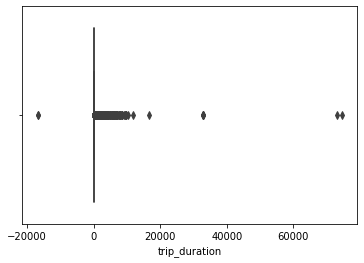

In [46]:
# 1.7: Lav et boxplot af trip_duration for at tjekke for outliers:
sns.boxplot(trips['trip_duration'])

Som det kan ses ser det helt underligt ud med mængden og størrelsen af de outliers der er. Vi vil derfor gerne forsøge, at manipulere vores datasæt så det kun indeholder starttidspunkter der er før dags dato og sluttidspunkter efter den første startsdato i vores DataFrame.

In [47]:
# 1.8: Hvad er den første dato i vores DataFrame?
trips['date_start'].min()

Timestamp('1970-01-01 00:00:00')

In [48]:
# 1.9: Filtrer trips, så startdatoer efter dags dato og slutdatoer før 1970-01-01 er filtreret væk.
trips = trips[
    (trips.date_end > '1970-01-01') &
    (trips.date_start < '2021-01-01')
]

Vi filtrerer på start- og slutdatoerne for, at få frasorteret de rækker, som ikke har en fornuftig værdi.

In [49]:
# 1.10: Hvad er min og max duration efter vi har filtreret vores dataframe?
print(trips.trip_duration.min())
print(trips.trip_duration.max())

0.0
74633.0


Som det kan ses har vi stadig trip_durations der er udenfor det vi ville forvente. Derfor er vi nødt at lave flere manipulationer af dataframen. Vi kan se på spredningen af vores trip_duration ved at udregne kvantiler. Her vil vi især gerne se kvantilerne 0.01 og 0.99:

In [50]:
# 1.11: Udregn kvantilerne 0.01, 0.25, 0.5, 0.75 og 0.99 i vores kolonne 'trip_duration'
trips.trip_duration.quantile([0.01,0.25,0.5,0.75,0.99])

0.01      0.00
0.25      3.00
0.50      7.00
0.75     23.00
0.99    639.32
Name: trip_duration, dtype: float64

Vi vil gerne have filtreret vores dataframe så vi kun har `trip_duration` der er mellem 0.01 kvantil og 0.99 kvantil. Vi kan derfor filtrere på vores DataFrame igen.

In [51]:
# 1.12: Filtrer vores trips DataFrame, så vi kun har data mellem 0.01 og 0.99 kvantiler på trips_duration:
# Vi kan filtrere vores kolonner som vi gjorde i 1.9. Her vil vi blot filtrere på trips['trip_duration'].quantile()
trips = trips[
    (trips['trip_duration'] > trips['trip_duration'].quantile(0.01)) &
    (trips['trip_duration'] < trips['trip_duration'].quantile(0.99))
]

Vi filtrerer her på `trip_duration` fordi vi efter vores filtrering stadig så nogle outliers i vores rejselængde som ikke gav mening. 

In [52]:
# 1.13: Tjek at trip_duration max og min er nogenlunde fornuftige nu:
print("Min. Duration is: ", trips['trip_duration'].min())
print("Max duration is: ", trips['trip_duration'].max())

Min. Duration is:  1.0
Max duration is:  638.0


Efter vi har klargjort vores `trips` DataFrame vil vi gerne have vores `trips` DataFrame og vores `country` DataFrame slået sammen. Dette kan vi gøre vha. funktionen `pd.merge()` funktionen. Vi har dog brug for, at se hvilke kolonner vores `country` DataFrame indeholder.

In [53]:
# 1.14: Hvilke kolonner indeholder vores country dataframe?
country.head()

,alpha_2,region,sub_region
0,AF,Asia,Southern Asia
1,AX,Europe,Northern Europe
2,AL,Europe,Southern Europe
3,DZ,Africa,Northern Africa
4,AS,Oceania,Polynesia


Her kan vi se at kolonnen `alpha_2` er den samme som vores kolonne `country_code` i trips dataframen. Vi vil derfor gerne omdøbe kolonnen `alpha_2` i vores country dataframe. Dette kan vi gøre vha. funktionen `df.rename()` hvor vi gerne vil gøre det inplace.

In [54]:
# 1.15: Omdøb kolonnen alpha_2 til country_code i country dataframen:
country.rename(columns={'alpha_2':'country_code'}, inplace=True)

Vi omdøber kolonnen `alpha_2` til `country_code` vha. funktionen `.rename`. Heri giver vi argumentet `columns={'alpha_2':'country_code'}`. Det vi giver argumentet i klammerne `{}` er i Python kaldet en dictionary (forkortet dict), som er en datatype. En dictionary har keys (nøgler) og values (værdier). Hver value har en key som den er knyttet op på. En value kan være hvilken som helst datatype, men keys skal være enten strings (tekststrenge), numbers (float eller integer), eller tuples (fx. (3,2)). Hvis i vil læse mere om dictionaries er her en fin guide: https://www.geeksforgeeks.org/python-dictionary/

Det er dog ikke nødvendigt, at kunne i dette fag.

In [55]:
# 1.16: Brug pd.merge til at merge de to dataframes på country_code:
merged = pd.merge(trips, country, on='country_code')

In [56]:
# 1.17: Hvordan ser de første 5 rækker ud af vores nye DataFrame?
merged.head()

,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug,trip_duration,region,sub_region
0,0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,2018-06-04,21,-101,Guanajuato,mexico,11.0,Americas,Latin America and the Caribbean
1,1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,2018-05-31,19,-99,Mexico City,mexico-city-mexico,3.0,Americas,Latin America and the Caribbean
2,2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,2017-11-01,21,-86,Cancun,cancun-mexico,4.0,Americas,Latin America and the Caribbean
3,62,@jtompl,Mexico,MX,mexico,2017-09-25,2017-09-10,19,-99,Mexico City,mexico-city-mexico,15.0,Americas,Latin America and the Caribbean
4,63,@jtompl,Mexico,MX,mexico,2017-09-10,2017-09-01,20,-87,Tulum,tulum-mexico,9.0,Americas,Latin America and the Caribbean


## 2 - Visualiseringer og Dataforståelse

In [57]:
# 2.1: Brug groupby til at give et overblik over gennemsnittet af trip_duration i de forskellige regioner:
merged.groupby('region').trip_duration.mean()

region
Africa      22.847027
Americas    28.952632
Asia        21.421855
Europe      23.861637
Oceania     32.518310
Name: trip_duration, dtype: float64

In [58]:
# 2.2: Brug groupby til at give et overblik over medianen af trip_duration i de forskellige regioner: 
merged.groupby('region').trip_duration.median()

region
Africa      7.0
Americas    7.0
Asia        7.0
Europe      6.0
Oceania     9.5
Name: trip_duration, dtype: float64

In [59]:
# 2.3: Brug groupby til at give et overblik over standardafvigelsen af trip_duration i de forskellige regioner: 
merged.groupby('region').trip_duration.std()

region
Africa      53.296241
Americas    64.994722
Asia        43.997037
Europe      58.184984
Oceania     63.528215
Name: trip_duration, dtype: float64

C:\Users\Sebastian Linde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


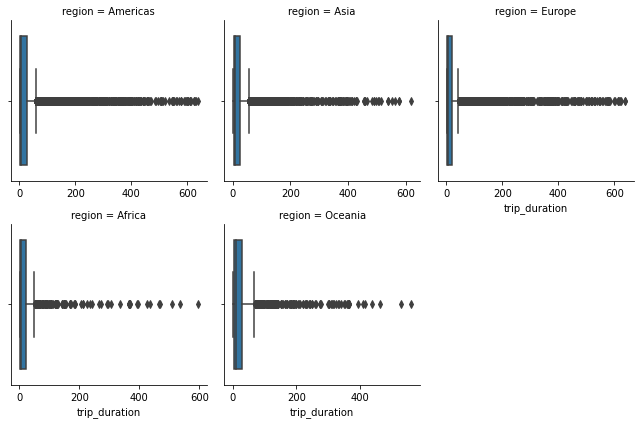

In [60]:
# 2.4: Lav et FacetGrid med boxplots der visualiserer spredningen af trip_duration i de forskellige regioner:
g = sns.FacetGrid(merged, col='region', col_wrap=3, sharex=False)
g.map(sns.boxplot, 'trip_duration')

Som det kan ses i de ovenstående boxplots, har vi stadig en del outliers. Dette er ikke en fejl, blot sådan vores data ser ud. Dette er også forventeligt ud fra hvordan gennemsnittet, medianen og standardafvigelsen er. Vi vil dog gerne prøve at se hvordan fordelingen er i interquartile range. For at gøre dette kan vi filtrere vores data ud fra vores viden om boxplots og outliers. Vi prøver at, lave et FacetGrid igen med merged DataFramen, men hvor vi filtrerer alle rækker med en trip_duration over 100 væk.

C:\Users\Sebastian Linde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


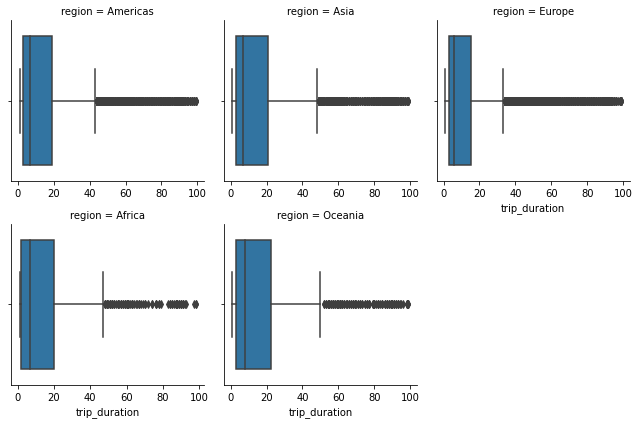

In [61]:
# 2.5: Lav et FacetGrid med boxplots der visualiserer spredningen af trip_duration i de forskellige regioner:
# Brug merged[merged.trip_duration < 100] som data
g = sns.FacetGrid(merged[merged.trip_duration < 100], col='region', col_wrap=3, sharex=False)
g.map(sns.boxplot, 'trip_duration')

In [62]:
# 2.6: Hvor mange lande er der i vores merged DataFrame? (Husk funktionen .nunique())
merged.country.nunique()

239

In [63]:
# 2.7: Hvilket land har modtaget flest besøgende?
merged.country.value_counts()

United States          7195
Thailand               3301
Spain                  1911
Germany                1868
France                 1428
                       ... 
Kurdistan                 1
Abkhazia                  1
Saint Barthélemy          1
Saint Martin              1
Khammouane Province       1
Name: country, Length: 239, dtype: int64

In [64]:
# 2.8: Hvilken region har modtaget færrest besøgende?
merged.region.value_counts()

Europe      14845
Asia        12592
Americas    12118
Africa       1497
Oceania      1420
Name: region, dtype: int64

## Idéer til ekstra øvelse:

Vi kigger nu på `people` DataFramen.

In [65]:
# Første 5 rækker af people
people.head()

,Unnamed: 0,username,followers,following,work_raw,education_raw
0,0,@lewellenmichael,1,2,"Software Dev, Startup Founder, Finance, Crypto...","High School, Bachelor's Degree"
1,1,@waylandchin,0,2,NaN,NaN
2,2,@karan,2,1,NaN,NaN
3,3,@skaboss217,0,1,NaN,NaN
4,4,@apwn,17,426,Web Dev,NaN


In [66]:
# Information om kolonnerne og dataen
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     4016 non-null   int64 
 1   username       4016 non-null   object
 2   followers      4016 non-null   int64 
 3   following      4016 non-null   int64 
 4   work_raw       1582 non-null   object
 5   education_raw  451 non-null    object
dtypes: int64(3), object(3)
memory usage: 188.4+ KB


Hvis i gerne vil arbejde videre med dataen her så kommer her nogle forslag:
* Det ser ud til, at der er en del rækker med manglende data i både work_raw og education_raw. Dette er ikke nødvendigvis en fejl, men det kan give os nogle udfordringer. Hvordan kan man få rettet disse fejl og få fyldt kolonnerne så dataen er sigende? (Overvej funktionen `.fillna()`).
* Nogle af rækkerne i `work_raw`og `education_raw` har flere værdier. Overvej hvordan vi kan gøre hvis vi gerne vil se antallet af fx. 'Startup Founder', antallet af folk med 'Master's Degree', eller antallet af 'Startup Founder' som også har en 'Bachelor's Degree'. Her er der en funktion der hedder `.contains()`, som kan bruges til at "søge" i tekststrenge, brug den som et filter. 
* Hvordan kan vi beregne hvem der har flest følgere som også er 'Startup Founder'.
* Forsøg, at brug `pd.merge()` til, at merge vores `merged` DataFrame med `people` DataFramen.
* Hvilket land besøger 'Startup Founder' mest?
* Af de folk der besøger regionen 'Europe' hvilken uddannelse har flest af dem?

Det er lidt eksempler på hvad i kunne arbejde lidt videre med. Men det er kun fantasien der sætter grænser. Så i kunne også arbejde med, at visualisere de forskellige ting, vha. de visualiseringsteknikker i har lært.